In [24]:
# ============================================================
# [단락 0] 라이브러리 + 한글 폰트
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ===============================
# 📌 한글 폰트 설정 (Windows)
# ===============================
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


df = pd.read_csv(
    r"C:\ai\lecNote\1st_project\data\금리시장면적_고용지표수정_인허가일자머지_인구머지_폐업률추가.csv",
    low_memory=False
)


In [4]:
# ============================================================
# [단락 1] 컬럼 정의
# ============================================================
num_cols = [
    "base_rate",
    "시설총규모",
    "인허가일자_경제활동참가율",
    "인허가일자_실업률",
    "인허가일자_고용률",
    "구별인구",
    "창업월",
]

cat_cols = [
    "업태_그룹",
    "구",
]

target_col = "폐업_3년이내"


In [15]:
# ============================================================
# [단락 2] 데이터 준비 (0/1만)
# ============================================================
use = df[num_cols + cat_cols + [target_col]].copy()
use = use[use[target_col].isin([0, 1])].copy()

X = use[num_cols + cat_cols].copy()
y = use[target_col].astype(np.float32).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Pos(1):", int((y_train==1).sum()), "Neg(0):", int((y_train==0).sum()))


Train: (189894, 9) Test: (47474, 9)
Pos(1): 59106 Neg(0): 130788


In [16]:
# ============================================================
# [단락 3] 수치형 전처리: 결측 + 표준화
# ============================================================
num_imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

Xtr_num = scaler.fit_transform(num_imputer.fit_transform(X_train[num_cols]))
Xte_num = scaler.transform(num_imputer.transform(X_test[num_cols]))


In [17]:
# ============================================================
# [단락 4] 범주형 라벨인코딩 + OOV(0)
# ============================================================
def build_vocab(series: pd.Series):
    uniques = pd.Series(series.dropna().astype(str).unique())
    return {v: i+1 for i, v in enumerate(uniques)}  # 1..N

def encode_with_oov(series: pd.Series, vocab: dict):
    s = series.fillna("__MISSING__").astype(str)
    return s.map(lambda x: vocab.get(x, 0)).astype("int32").values

vocab_biz = build_vocab(X_train["업태_그룹"])
vocab_gu  = build_vocab(X_train["구"])

Xtr_biz = encode_with_oov(X_train["업태_그룹"], vocab_biz)
Xte_biz = encode_with_oov(X_test["업태_그룹"], vocab_biz)

Xtr_gu  = encode_with_oov(X_train["구"], vocab_gu)
Xte_gu  = encode_with_oov(X_test["구"], vocab_gu)

biz_vocab_size = len(vocab_biz) + 1
gu_vocab_size  = len(vocab_gu)  + 1


In [18]:
# ============================================================
# [단락 5] class_weight (완화: sqrt)
# ============================================================
neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
w1 = float(np.sqrt(neg / max(pos, 1)))
class_weight = {0: 1.0, 1: w1}
print("class_weight:", class_weight)


class_weight: {0: 1.0, 1: 1.4875383279530061}


In [19]:
# ============================================================
# [단락 6] 임베딩 모델
# ============================================================
def emb_dim(vocab_size):
    return int(min(32, max(4, round(vocab_size ** 0.25 * 8))))

biz_emb_dim = emb_dim(biz_vocab_size)
gu_emb_dim  = emb_dim(gu_vocab_size)

inp_num = layers.Input(shape=(len(num_cols),), name="num")
inp_biz = layers.Input(shape=(), dtype="int32", name="biz_id")
inp_gu  = layers.Input(shape=(), dtype="int32", name="gu_id")

emb_biz = layers.Embedding(biz_vocab_size, biz_emb_dim, name="emb_biz")(inp_biz)
emb_gu  = layers.Embedding(gu_vocab_size,  gu_emb_dim,  name="emb_gu")(inp_gu)
emb_biz = layers.Flatten()(emb_biz)
emb_gu  = layers.Flatten()(emb_gu)

x = layers.Concatenate()([inp_num, emb_biz, emb_gu])

x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.30)(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.20)(x)

out = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=[inp_num, inp_biz, inp_gu], outputs=out)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.AUC(name="auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="acc"),  # ✅ 학습 중 acc
    ]
)

model.summary()
print("Embedding dims:", {"biz": biz_emb_dim, "gu": gu_emb_dim})


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 biz_id (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 gu_id (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 emb_biz (Embedding)            (None, 13)           104         ['biz_id[0][0]']                 
                                                                                                  
 emb_gu (Embedding)             (None, 18)           468         ['gu_id[0][0]']                  
                                                                                            

In [20]:
# ============================================================
# [단락 7] 학습
# ============================================================
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=3, min_lr=1e-5, verbose=1)
]

history = model.fit(
    {"num": Xtr_num, "biz_id": Xtr_biz, "gu_id": Xtr_gu},
    y_train,
    validation_split=0.2,
    epochs=60,
    batch_size=256,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)


Epoch 1/60
594/594 [==============================] - 4s 5ms/step - loss: 0.7881 - auc: 0.5584 - precision: 0.3689 - recall: 0.2348 - acc: 0.6366 - val_loss: 0.6265 - val_auc: 0.6056 - val_precision: 0.4447 - val_recall: 0.1817 - val_acc: 0.6753 - lr: 0.0010
Epoch 2/60
594/594 [==============================] - 3s 5ms/step - loss: 0.7614 - auc: 0.5972 - precision: 0.4296 - recall: 0.2141 - acc: 0.6667 - val_loss: 0.6248 - val_auc: 0.6159 - val_precision: 0.4449 - val_recall: 0.2479 - val_acc: 0.6703 - lr: 0.0010
Epoch 3/60
594/594 [==============================] - 3s 5ms/step - loss: 0.7572 - auc: 0.6075 - precision: 0.4410 - recall: 0.2303 - acc: 0.6694 - val_loss: 0.6221 - val_auc: 0.6188 - val_precision: 0.4514 - val_recall: 0.2660 - val_acc: 0.6716 - lr: 0.0010
Epoch 4/60
594/594 [==============================] - 3s 5ms/step - loss: 0.7556 - auc: 0.6110 - precision: 0.4488 - recall: 0.2385 - acc: 0.6716 - val_loss: 0.6215 - val_auc: 0.6197 - val_precision: 0.4485 - val_recall: 0.

In [21]:
# ============================================================
# [단락 8] 예측 + AUC
# ============================================================
proba = model.predict({"num": Xte_num, "biz_id": Xte_biz, "gu_id": Xte_gu}, verbose=0).reshape(-1)
roc_auc = roc_auc_score(y_test, proba)
print("ROC-AUC:", roc_auc)


ROC-AUC: 0.6181433145262656


In [25]:
# ============================================================
# [단락 9] ✅ Precision≈Recall 균형 threshold 선택 + Accuracy 포함 출력
# ============================================================
ths = np.arange(0.05, 0.96, 0.01)
rows = []
for th in ths:
    pred = (proba >= th).astype(int)
    pr = precision_score(y_test, pred, zero_division=0)
    rc = recall_score(y_test, pred, zero_division=0)
    f1 = f1_score(y_test, pred, zero_division=0)
    acc = accuracy_score(y_test, pred)              # ✅ accuracy
    diff = abs(pr - rc)
    pos_rate = pred.mean()
    rows.append((th, pr, rc, f1, acc, diff, pos_rate))

tbl = pd.DataFrame(rows, columns=["th","precision","recall","f1","accuracy","diff_pr_rc","pred_pos_rate"])

MIN_RECALL = 0.05
MIN_POS_RATE = 0.005
cand = tbl[(tbl["recall"] >= MIN_RECALL) & (tbl["pred_pos_rate"] >= MIN_POS_RATE)].copy()

if len(cand) == 0:
    chosen = tbl.sort_values("f1", ascending=False).iloc[0]
else:
    chosen = cand.sort_values(["diff_pr_rc","f1"], ascending=[True, False]).iloc[0]

th = float(chosen["th"])
pred = (proba >= th).astype(int)

print("Chosen (Precision≈Recall with constraints):")
print(chosen)

print(f"\n[CHOSEN Threshold={th:.2f}]")
print(f"ROC-AUC   : {roc_auc:.4f}")
print(f"Accuracy  : {accuracy_score(y_test, pred):.4f}")          # ✅ 추가
print(f"Precision : {precision_score(y_test, pred, zero_division=0):.4f}")
print(f"Recall    : {recall_score(y_test, pred, zero_division=0):.4f}")
print(f"F1        : {f1_score(y_test, pred, zero_division=0):.4f}")
print(f"Pred_Pos_Rate: {pred.mean():.4f}")

print("\nConfusion Matrix:\n", confusion_matrix(y_test, pred))
print("\nReport:\n", classification_report(y_test, pred, digits=4))


Chosen (Precision≈Recall with constraints):
th               0.460000
precision        0.420680
recall           0.426744
f1               0.423691
accuracy         0.638644
diff_pr_rc       0.006064
pred_pos_rate    0.315752
Name: 41, dtype: float64

[CHOSEN Threshold=0.46]
ROC-AUC   : 0.6181
Accuracy  : 0.6386
Precision : 0.4207
Recall    : 0.4267
F1        : 0.4237
Pred_Pos_Rate: 0.3158

Confusion Matrix:
 [[24013  8684]
 [ 8471  6306]]

Report:
               precision    recall  f1-score   support

         0.0     0.7392    0.7344    0.7368     32697
         1.0     0.4207    0.4267    0.4237     14777

    accuracy                         0.6386     47474
   macro avg     0.5800    0.5806    0.5803     47474
weighted avg     0.6401    0.6386    0.6393     47474



Best threshold(F1): 0.33 | Best F1: 0.4883


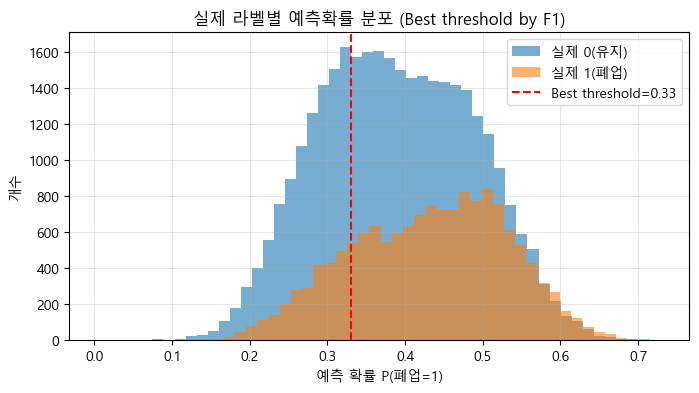

In [39]:
# ============================================================
# (1) F1 기준 Best threshold 찾기
# ============================================================
thresholds = np.arange(0.05, 0.96, 0.01)
f1_scores = []

for t in thresholds:
    pred_t = (proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, pred_t, zero_division=0))

f1_scores = np.array(f1_scores)
best_idx = np.argmax(f1_scores)
best_th = float(thresholds[best_idx])

print(f"Best threshold(F1): {best_th:.2f} | Best F1: {f1_scores[best_idx]:.4f}")

# ============================================================
# (2) 실제 라벨별 예측확률 분포 + best threshold(빨간 점선)
# ============================================================
plt.figure(figsize=(8,4))
plt.hist(proba[y_test==0], bins=50, alpha=0.6, label="실제 0(유지)")
plt.hist(proba[y_test==1], bins=50, alpha=0.6, label="실제 1(폐업)")
plt.axvline(best_th, color="red", linestyle="--", label=f"Best threshold={best_th:.2f}")

plt.xlabel("예측 확률 P(폐업=1)")
plt.ylabel("개수")
plt.title("실제 라벨별 예측확률 분포 (Best threshold by F1)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

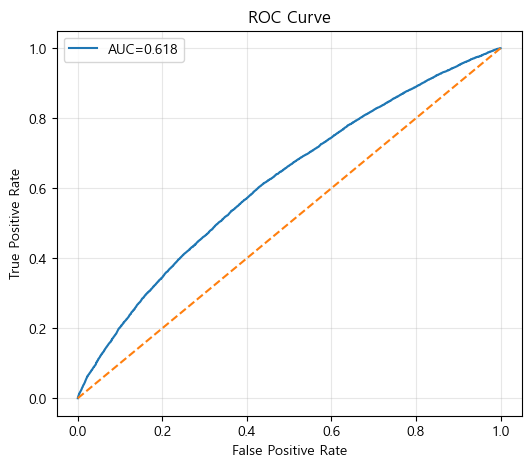

In [29]:
# ============================================================
# [시각화 2] ROC Curve + AUC
# ============================================================
from sklearn.metrics import roc_curve, roc_auc_score

roc_auc = roc_auc_score(y_test, proba)
fpr, tpr, _ = roc_curve(y_test, proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


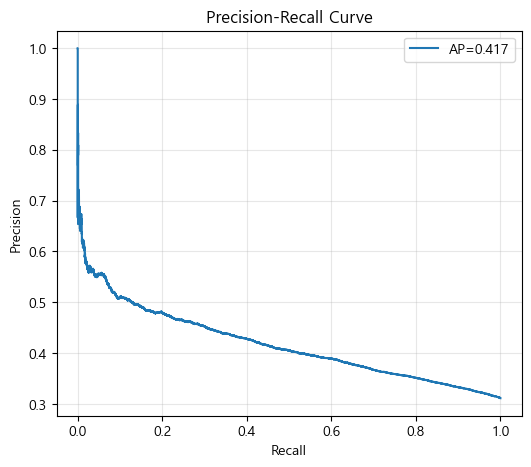

In [30]:
# ============================================================
# [시각화 3] Precision-Recall Curve + AP
# ============================================================
from sklearn.metrics import precision_recall_curve, average_precision_score

p, r, _ = precision_recall_curve(y_test, proba)
ap = average_precision_score(y_test, proba)

plt.figure(figsize=(6,5))
plt.plot(r, p, label=f"AP={ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Best threshold(F1): 0.33 | Best F1: 0.4883
Pred positive rate: 0.7288831781606774
Confusion Matrix:
 [[10150 22547]
 [ 2721 12056]]


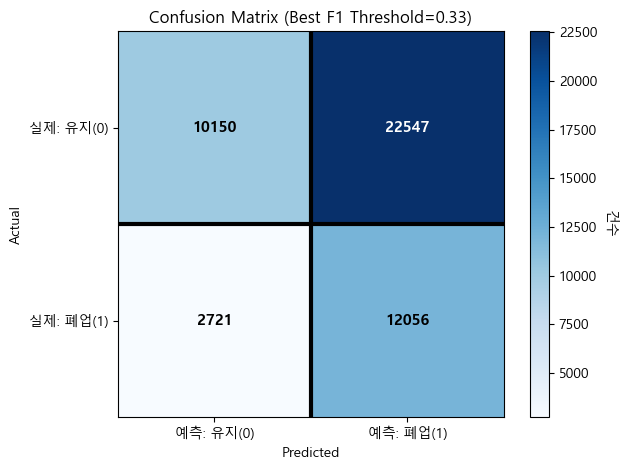

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

# 0) 타입/정렬 꼬임 방지: 무조건 numpy로 고정
y_true = np.asarray(y_test).astype(int).reshape(-1)
p = np.asarray(proba).reshape(-1)

assert len(y_true) == len(p), f"길이 다름! y_test={len(y_true)}, proba={len(p)}"

# 1) best threshold(F1) 찾기
thresholds = np.arange(0.05, 0.96, 0.01)
f1s = []
for t in thresholds:
    pred_t = (p >= t).astype(int)
    f1s.append(f1_score(y_true, pred_t, zero_division=0))

f1s = np.array(f1s)
best_th = float(thresholds[np.argmax(f1s)])

# 2) best threshold로 pred 생성 (여기서 pred "확정")
pred = (p >= best_th).astype(int)

print(f"Best threshold(F1): {best_th:.2f} | Best F1: {f1s.max():.4f}")
print("Pred positive rate:", pred.mean())

# 3) confusion matrix (labels 고정해서 순서 꼬임 방지)
cm = confusion_matrix(y_true, pred, labels=[0, 1])
cm_rate = cm / cm.sum(axis=1, keepdims=True)

print("Confusion Matrix:\n", cm)

fig, ax = plt.subplots(figsize=(6.4, 4.8))

im = ax.imshow(cm, cmap="Blues", aspect="equal")   # ✅ 건수 기준(예시 이미지랑 동일)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("건수", rotation=270, labelpad=14)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["예측: 유지(0)", "예측: 폐업(1)"])
ax.set_yticklabels(["실제: 유지(0)", "실제: 폐업(1)"])

ax.set_title(f"Confusion Matrix (Best F1 Threshold={best_th:.2f})")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

# ✅ 2x2 범위 고정(안정)
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(1.5, -0.5)

# ✅ 가운데 십자선 굵게
ax.axhline(0.5, color="black", linewidth=3.0)
ax.axvline(0.5, color="black", linewidth=3.0)

# ✅ 텍스트: 건수만(예시 이미지 스타일)
maxv = cm.max()
for i in range(2):
    for j in range(2):
        v = cm[i, j]
        txt_color = "white" if v > maxv * 0.55 else "black"
        ax.text(j, i, f"{v}", ha="center", va="center",
                fontsize=11, fontweight="bold", color=txt_color)

plt.tight_layout()
plt.show()



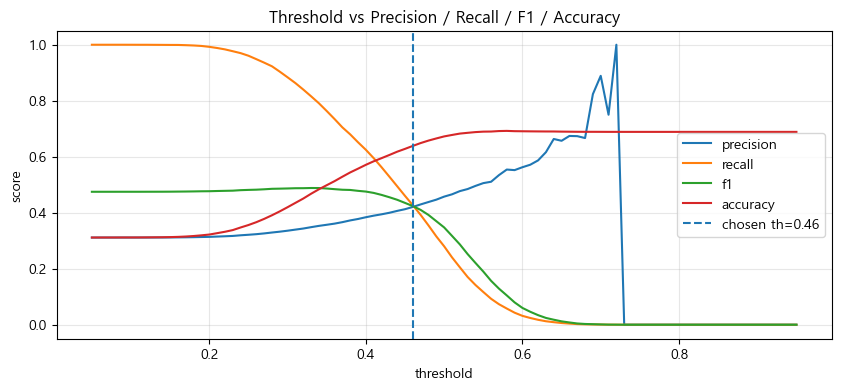

In [32]:
# ============================================================
# [시각화 5] Threshold vs Precision/Recall/F1 (+ accuracy 있으면 같이)
#   - tbl에 accuracy 컬럼이 있으면 자동으로 그림
# ============================================================
plt.figure(figsize=(10,4))
plt.plot(tbl["th"], tbl["precision"], label="precision")
plt.plot(tbl["th"], tbl["recall"], label="recall")
plt.plot(tbl["th"], tbl["f1"], label="f1")
if "accuracy" in tbl.columns:
    plt.plot(tbl["th"], tbl["accuracy"], label="accuracy")
plt.axvline(th, linestyle="--", label=f"chosen th={th:.2f}")
plt.xlabel("threshold")
plt.ylabel("score")
plt.title("Threshold vs Precision / Recall / F1" + (" / Accuracy" if "accuracy" in tbl.columns else ""))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


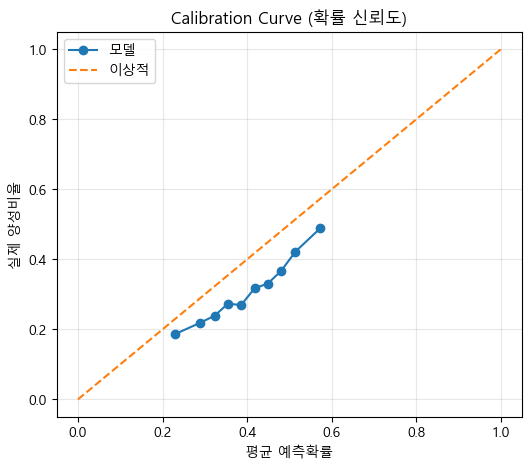

In [33]:
# ============================================================
# [시각화 6] (추천) Calibration Curve: 확률이 '진짜 확률'처럼 맞는지
# ============================================================
from sklearn.calibration import calibration_curve

frac_pos, mean_pred = calibration_curve(y_test, proba, n_bins=10, strategy="quantile")

plt.figure(figsize=(6,5))
plt.plot(mean_pred, frac_pos, marker="o", label="모델")
plt.plot([0,1],[0,1], linestyle="--", label="이상적")
plt.xlabel("평균 예측확률")
plt.ylabel("실제 양성비율")
plt.title("Calibration Curve (확률 신뢰도)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


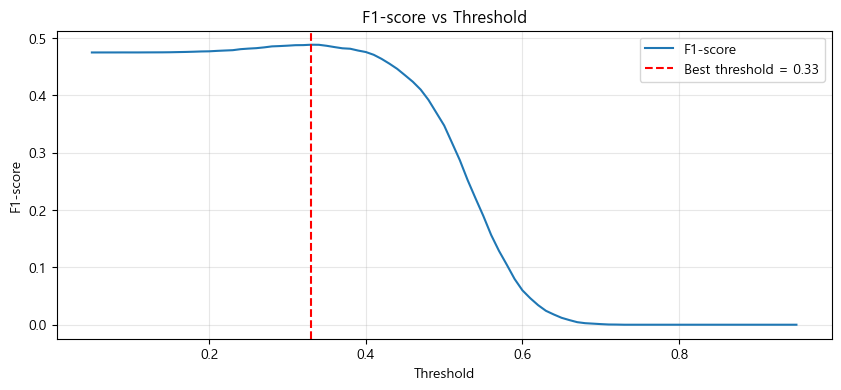

Best threshold: 0.33
Best F1-score : 0.4883


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

thresholds = np.arange(0.05, 0.96, 0.01)
f1_scores = []

for th in thresholds:
    pred = (proba >= th).astype(int)
    f1_scores.append(f1_score(y_test, pred, zero_division=0))

f1_scores = np.array(f1_scores)

best_idx = np.argmax(f1_scores)
best_th = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

plt.figure(figsize=(10, 4))

# ✅ 파란색 선 (기본값이 파랑)
plt.plot(thresholds, f1_scores, color="tab:blue", label="F1-score")

# ✅ 빨간 점선 (위 이미지처럼)
plt.axvline(best_th, color="red", linestyle="--", label=f"Best threshold = {best_th:.2f}")

plt.title("F1-score vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Best threshold: {best_th:.2f}")
print(f"Best F1-score : {best_f1:.4f}")


Best threshold(F1): 0.33
Precision: 0.3484 | Recall: 0.8159 | F1: 0.4883


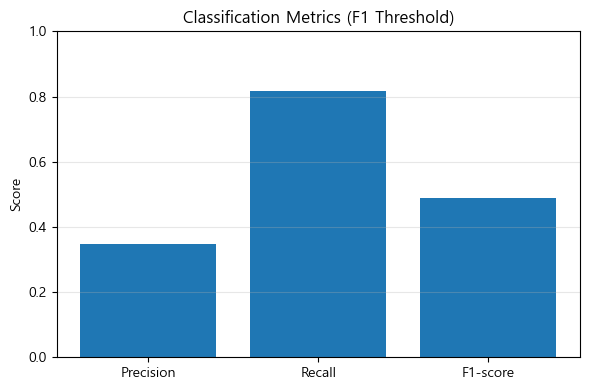

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# ============================================================
# 1) Best threshold (F1) 찾기
# ============================================================
y_true = np.asarray(y_test).astype(int).reshape(-1)
p = np.asarray(proba).reshape(-1)

thresholds = np.arange(0.05, 0.96, 0.01)
f1s = []

for t in thresholds:
    pred_t = (p >= t).astype(int)
    f1s.append(f1_score(y_true, pred_t, zero_division=0))

f1s = np.array(f1s)
best_th = float(thresholds[np.argmax(f1s)])

# Best threshold로 최종 예측
pred = (p >= best_th).astype(int)

# 지표 계산
prec = precision_score(y_true, pred, zero_division=0)
rec = recall_score(y_true, pred, zero_division=0)
f1 = f1_score(y_true, pred, zero_division=0)

print(f"Best threshold(F1): {best_th:.2f}")
print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

# ============================================================
# 2) 막대그래프 시각화 (이미지처럼)
# ============================================================
labels = ["Precision", "Recall", "F1-score"]
values = [prec, rec, f1]

plt.figure(figsize=(6,4))
plt.bar(labels, values)  # ✅ 기본 파란색
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Classification Metrics (F1 Threshold)")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
